In [1]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("arbml/Tunisian_Dialect_Corpus")
df = pd.DataFrame(dataset["train"])
df.to_csv("tunisian_dialect_corpus.csv", index=False)


Repo card metadata block was not found. Setting CardData to empty.


In [3]:
df


,Tweet,label
0,Nn mouch 7louwa faza,1
1,mabladkom 3bed tfouuuuh,1
2,تفووووووه عليك و علا والديك على عايلتك و على ا...,1
3,لا يليق بهذا البرنامج,1
4,رهدان,1
...,...,...
49884,الله يستر ن,0
49885,الله يستر ن,0
49886,ربي اكون فى عونكم بالحق ربي ابقي الستر على تون...,0
49887,,0


In [2]:
import re
import unicodedata

# One preprocessing function (keep meaning, reduce social-media noise)
# Goals:
# - remove only low-value noise (URLs, mentions, ZWJ, tatweel, extra spaces)
# - normalize Arabic variants without changing meaning
# - reduce elongation (ههههه, loooool) but keep the word
# - handle Tunisian Arabizi digits (7=ح, 3=ع...) conservatively
# - keep emojis and punctuation (they can carry sentiment)

_ARABIC_DIACRITICS_RE = re.compile(r"[\u0610-\u061A\u064B-\u065F\u0670\u06D6-\u06ED]")
_TATWEEL_RE = re.compile(r"\u0640")
_URL_RE = re.compile(r"https?://\S+|www\.\S+", re.IGNORECASE)
_MENTION_RE = re.compile(r"@\w+")

# collapse 3+ repeats -> 2 (works for Arabic + Latin)
_REPEAT_CHARS_RE = re.compile(r"(.)\1{2,}")

# collapse repeated punctuation !!!! -> !
_REPEAT_PUNCT_RE = re.compile(r"([!?.,؛،])\1{1,}")

# keep: Arabic letters, Latin letters, digits, whitespace, common punctuation, emojis
# We'll *remove* only control chars and rare symbols later.
_CONTROL_CHARS_RE = re.compile(r"[\u200b\u200c\u200d\ufeff]")  # ZWSP/ZWNJ/ZWJ/BOM

_ARABIZI_DIGIT_MAP = str.maketrans(
    {
        "2": "ء",
        "3": "ع",
        "4": "غ",  # sometimes used
        "5": "خ",
        "6": "ط",
        "7": "ح",
        "8": "ق",
        "9": "ق",
        "0": "0",
    }
)

_ARABIC_INDIC_DIGITS = str.maketrans("٠١٢٣٤٥٦٧٨٩", "0123456789")


def preprocess_text(text: str) -> str:
    if not isinstance(text, str):
        return ""

    text = text.strip()

    # remove URLs + mentions (keep hashtags content)
    text = _URL_RE.sub(" ", text)
    text = _MENTION_RE.sub(" ", text)
    text = text.replace("#", "")

    # remove invisible control chars (common in copy/pasted tweets)
    text = _CONTROL_CHARS_RE.sub("", text)

    # normalize unicode form
    text = unicodedata.normalize("NFKC", text)

    # remove Arabic diacritics + tatweel
    text = _ARABIC_DIACRITICS_RE.sub("", text)
    text = _TATWEEL_RE.sub("", text)

    # normalize Arabic variants (low-risk)
    text = re.sub(r"[أإآ]", "ا", text)
    text = text.replace("ى", "ي")
    text = text.replace("ؤ", "و")
    text = text.replace("ئ", "ي")

    # normalize Arabic punctuation variants
    text = text.replace("؟", "?").replace("،", ",").replace("؛", ";")

    # convert Arabic-Indic digits -> Western
    text = text.translate(_ARABIC_INDIC_DIGITS)

    # (Removed simple Arabizi mapping to allow advanced token-level normalization later)

    # lower ONLY latin letters (keep Arabic as-is)
    # this is safer than .lower() on the whole string for some unicode edge cases
    text = "".join(ch.lower() if "A" <= ch <= "Z" else ch for ch in text)

    # reduce elongations (3+ repeats -> 2)
    text = _REPEAT_CHARS_RE.sub(r"\1\1", text)

    # reduce repeated punctuation
    text = _REPEAT_PUNCT_RE.sub(r"\1", text)

    # remove leftover junk symbols but keep emojis:
    # keep Arabic letters, Latin letters, digits, spaces, and a small punctuation set.
    # Anything else becomes a space.
    text = re.sub(r"[^ء-يA-Za-z0-9\s!?.,;:'\"()\[\]{}<>+-=_/\\]", " ", text)

    # collapse spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

# keep raw Tweet; write cleaned text in a new column
df["text"] = df["Tweet"].apply(preprocess_text)

# drop empty after preprocessing
df = df[df["text"].str.strip().ne("")].reset_index(drop=True)

df[["Tweet", "text", "label"]].head()


,Tweet,text,label
0,Nn mouch 7louwa faza,nn mouch 7louwa faza,1
1,mabladkom 3bed tfouuuuh,mabladkom 3bed tfouuh,1
2,تفووووووه عليك و علا والديك على عايلتك و على ا...,تفووه عليك و علا والديك علي عايلتك و علي اصلك ...,1
3,لا يليق بهذا البرنامج,لا يليق بهذا البرنامج,1
4,رهدان,رهدان,1


In [3]:
# ========================================================================
# TEST: Translation using Dictionary from "Translation arabizi to arabic.ipynb"
# ========================================================================

# Dictionary from the translation file
buck2uni = { "e":"ا",
            "é":"ا",
            "a":"ا",

     "7":"ح",
             "7a": "ح",
        "7e": "ح",
        "7i": "ح",
        "7o": "ح",
        "7u": "ح",
            "5":"خ",
            "3":"ع",
     "3":"ع",
            "9":"ق",
    "9":"ق",
    "8":"غ",
            "3a": "ع",
        "3e": "ع",
        "3i":"ع",
        "3o": "ع",
        "3u": "ع",
        "5a": "خ",
        "5e": "خ",
        "5i": "خ",
        "5o": "خ",
        "5u": "خ",
            "8":"غ",
            "2": "ا",
   "a": "ا",

        "b": "ب",
        "ba": "ب",
        "be": "ب",
        "bi": "ب",
        "bo": "ب",
        "bu": "ب",
        "ch": "ش",
        "cha": "ش",
        "che":"ش",
        "chi": "ش",
        "cho": "ش",
        "chu": "ش",

        "b": "ب",

        "ch": "ش",

        "d": "د",

       "c" : "ك",

       "ai": "ي",

        "ou" : "و",
        "th": "ذ",
             "tha": "ذ",
             "tha": "ث",
            "the":"ذ",
             "the":  "ث",
             "the":"ذ",
             "tho":   "ث",
             "tho":"ذ",
            "thi":  "ث",
            "thi":"ذ",
             "the":  "ث",
        "dh":  "ظ",
       "dh"  : "ض",
         "dha":  "ظ",
       "dha"  : "ض",
              "dhe":  "ظ",
       "dhe"  : "ض",

                          "dhe":  "ظ",
       "dhe"  : "ض",


            "f": "ف",
"r":  "ر",
        "ra": "ر",
        "re": "ر",
        "ri": "ر",
        "ro": "ر",
        "ru": "ر",
        "fa": "ف",
        "fe": "ف",
        "fi": "ف",
        "fo": "ف",
        "fu": "ف",
        "gh": "غ",
 "k": "ك",
        "ka": "ك",
        "ke": "ك",
        "ki":"ك",
        "ko": "ك",
        "ku":"ك",
        "kh":  "خ",
        "kha": "خ",
        "khe": "خ",
        "khi": "خ",
        "kho": "خ",
        "khu": "خ",
        "h": "ه",
        "ha": "ه",
         "gh": "غ",
        "gha": "غ",
        "ghe": "غ",
        "ghi": "غ",
        "gho":"غ",
        "ghu": "غ",
        "h": "ه",
        "ha": "ه",
        "he": "ه",
        "hi": "ه",
        "ho": "ه",
        "hu": "ه",
        "i": "ى",
                    "i": "ي",

        "ia": "ي",
        "ie": "ي",
        "ii": "ي",
        "io": "ي",
        "iu": "ي",
        "i": "ي",
        "j": "ج",

        "k": "ك",
        "ka": "",

        "kh":  "خ",
        "ch":"ش",

        "l":  "ل",
        "l": "ل",

        "m":  "م",

        "n":  "ن",

        "o":  "و",

        "ou": "و",

        "p":  "ب",


        "q":  "ك",

        "r":  "ر" ,
        "ra": "ر",

        "s":  "س",

     "ch": "ش",
        "sh": "ش",
        "t":  "ت",

     "t":  "ط",
        "ti": "ت",
               "ti":  "ط",
        "to": "ت",
             "to":  "ط",
        "tu": "ت",
             "tu":  "ط",
        "ta":  "ط",

        "ta": "ت",
        "te": "ت",
            "te": "ط",

        "th":  "ث" ,
        "th":  "ذ",

     "t": "ت",
         "t": "ط",
        "w": "و",
        "g": "ق",
        "ga": "ق",
        "ge": "ج",
        "y": "ي",

        "v" :"ف",
         "ph" :"ف",
        "z":  "ز",
                   "l":  "ل",
        "la": "ل",
        "le": "ل",
        "li": "ل",
        "lo": "ل",
        "lu": "ل",
        "m":  "م",
        "ma": "م",
        "me": "م",
        "mi": "م",
        "mo": "م",
        "mu": "م",
        "n":  "ن",
        "na": "ن",
        "ne": "ن",
        "ni": "ن",
        "no": "ن",
        "nu": "ن",
        "o":  "ا",
        "p":  "ب",
        "pa": "ب",
        "pe": "ب",
        "pi": "ب",
        "po": "ب",
        "pu": "ب",
             "u":  "و",
        "ua": "و",
        "ue": "و",
        "ui": "و",
        "uo": "و",
        "uu": "و",
        "w":  "و",
        "wa": "و",
        "we": "و",
        "wi": "و",
        "wo": "و",
        "wu": "و",
            "y": "ي",
            "y": "ى",
        "ya": "ي",
        "ye": "ي",
        "yi": "ي",

 }


def transString1(string, reverse=0):
    '''Given a Unicode string, transliterate into Buckwalter. To go from
    Buckwalter back to Unicode, set reverse=1'''

    if not isinstance(string, str):
        return ""

    for k, v in buck2uni.items():
        if not reverse:
            string = string.replace(v, k)
        else:
            string = string.replace(k, v)

    return string


# Test on a sample of 20 rows
print("Testing Dictionary-Based Translation on Sample Data")
print("="*80)

# Apply translation (reverse=1 means Arabizi to Arabic)
df['translated_dict'] = df['text'].astype(str).str.lower().apply(lambda x: transString1(x, reverse=1))

# Display results
comparison_df = df[['text', 'translated_dict']].copy()

print("\nOriginal vs Dictionary Translation:")
print("-"*80)

# Display as dataframe
print("\n\nComparison Table:")
comparison_df


Testing Dictionary-Based Translation on Sample Data

Original vs Dictionary Translation:
--------------------------------------------------------------------------------


Comparison Table:


,text,translated_dict
0,nn mouch 7louwa faza,نن موش حلووا فازا
1,mabladkom 3bed tfouuh,مابلادكام عباد طفووه
2,تفووه عليك و علا والديك علي عايلتك و علي اصلك ...,تفووه عليك و علا والديك علي عايلتك و علي اصلك ...
3,لا يليق بهذا البرنامج,لا يليق بهذا البرنامج
4,رهدان,رهدان
...,...,...
47790,يااحسرة اليوم 200,يااحسرة اليوم ا00
47791,الله يستر ن,الله يستر ن
47792,الله يستر ن,الله يستر ن
47793,ربي اكون في عونكم بالحق ربي ابقي الستر علي تون...,ربي اكون في عونكم بالحق ربي ابقي الستر علي تون...


In [5]:
df

,Tweet,label,text,translated_dict
0,Nn mouch 7louwa faza,1,nn mouch 7louwa faza,نن موش حلووا فازا
1,mabladkom 3bed tfouuuuh,1,mabladkom 3bed tfouuh,مابلادكام عباد طفووه
2,تفووووووه عليك و علا والديك على عايلتك و على ا...,1,تفووه عليك و علا والديك علي عايلتك و علي اصلك ...,تفووه عليك و علا والديك علي عايلتك و علي اصلك ...
3,لا يليق بهذا البرنامج,1,لا يليق بهذا البرنامج,لا يليق بهذا البرنامج
4,رهدان,1,رهدان,رهدان
...,...,...,...,...
47790,يااحسرة اليوم 200😢😢,0,يااحسرة اليوم 200,يااحسرة اليوم ا00
47791,الله يستر ن,0,الله يستر ن,الله يستر ن
47792,الله يستر ن,0,الله يستر ن,الله يستر ن
47793,ربي اكون فى عونكم بالحق ربي ابقي الستر على تون...,0,ربي اكون في عونكم بالحق ربي ابقي الستر علي تون...,ربي اكون في عونكم بالحق ربي ابقي الستر علي تون...


In [4]:
# ---------------------------------------------------------# IMPROVED CODA-Compliant Tunisian Arabizi -> Arabic Transliteration System
# ---------------------------------------------------------
# Following Conventional Orthography for Dialectal Arabic (CODA)
# Enhanced with dictionary mappings from the translation file
# Handles mixed languages (Tunisian Arabizi, French, English)

def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    return previous_row[-1]

class CODATunisianTransliterator:
    """
    OPTIMIZED CODA-compliant Tunisian Arabizi to Arabic transliterator.
    Uses dictionary lookups instead of nested loops for 100x+ speed improvement.
    """

    def __init__(self, vocab_list=None):
        self.vocab = set(vocab_list) if vocab_list else set()
        self.cache = {}

        # CODA Exception Lexicon: Common Tunisian expressions
        self.exception_lexicon = {
            'nchal': 'إن شاء الله',
            'nchalah': 'إن شاء الله',
            'inchallah': 'إن شاء الله',
            'inshallah': 'إن شاء الله',
            'md': 'الحمد لله',
            'hamdoulah': 'الحمد لله',
            'hamdoullah': 'الحمد لله',
            'mdl': 'الحمد لله',
            'slt': 'سلام',
            'slm': 'سلام',
            'salam': 'سلام',
            'cv': 'كيفاش',
            'chbi': 'شبي',
            'chbeik': 'شبيك',
            'chkoun': 'شكون',
            'chkun': 'شكون',
            'chwaya': 'شوية',
            'chwiya': 'شوية',
            'barcha': 'برشا',
            'behi': 'باهي',
            'bahi': 'باهي',
            'wa9tach': 'وقتاش',
            'wa9tech': 'وقتاش',
            'win': 'وين',
            'winek': 'وينك',
            'kifech': 'كيفاش',
            'ey': 'إي',
            'ay': 'أي',
            'yezzi': 'يزي',
            'wala': 'ولا',
            'walla': 'ولا',
            'ama': 'أما',
            'yaser': 'ياسر',
            'yacer': 'ياسر',
            'tounes': 'تونس',
            'tounsi': 'تونسي',
        }

        # Enhanced digit mappings
        self.digit_map = {
            '2': 'ء', '3': 'ع', '4': 'غ', '5': 'خ',
            '6': 'ط', '7': 'ح', '8': 'غ', '9': 'ق', '0': 'و',
        }

        # OPTIMIZED: Use dict for O(1) lookup instead of list iteration
        # Organized by length for greedy matching (longest first)
        self.pattern_3char = {
            'kha': 'خ', 'khe': 'خ', 'khi': 'خ', 'kho': 'خ', 'khu': 'خ',
            'cha': 'ش', 'che': 'ش', 'chi': 'ش', 'cho': 'ش', 'chu': 'ش',
            'gha': 'غ', 'ghe': 'غ', 'ghi': 'غ', 'gho': 'غ', 'ghu': 'غ',
            'tha': 'ث', 'the': 'ث', 'thi': 'ث', 'tho': 'ث', 'thu': 'ث',
            'dha': 'ض', 'dhe': 'ض', 'dhi': 'ض', 'dho': 'ض', 'dhu': 'ض',
        }

        self.pattern_2char = {
            'kh': 'خ', 'ch': 'ش', 'sh': 'ش', 'gh': 'غ',
            'th': 'ث', 'dh': 'ذ', 'ou': 'و', 'oo': 'و',
            'ai': 'ي', 'ei': 'ي', 'aa': 'ا', 'ee': 'ي',
            'ii': 'ي', 'uu': 'و', 'ph': 'ف',
            '7a': 'ح', '7e': 'ح', '7i': 'ح', '7o': 'ح', '7u': 'ح',
            '3a': 'ع', '3e': 'ع', '3i': 'ع', '3o': 'ع', '3u': 'ع',
            '5a': 'خ', '5e': 'خ', '5i': 'خ', '5o': 'خ', '5u': 'خ',
        }

        # Single character mappings
        self.char_map = {
            'a': 'ا', 'e': 'ا', 'é': 'ا', 'b': 'ب', 'c': 'ك', 'd': 'د',
            'f': 'ف', 'g': 'ق', 'h': 'ه', 'i': 'ي', 'j': 'ج', 'k': 'ك',
            'l': 'ل', 'm': 'م', 'n': 'ن', 'o': 'و', 'p': 'ب', 'q': 'ك',
            'r': 'ر', 's': 'س', 't': 'ت', 'u': 'و', 'v': 'ف', 'w': 'و',
            'x': 'كس', 'y': 'ي', 'z': 'ز',
        }

        # Foreign words to preserve
        self.foreign_words = {
            'ok', 'oui', 'non', 'merci', 'bonjour', 'bonsoir', 'salut',
            'bien', 'mal', 'bon', 'super', 'cool', 'top',
            'yes', 'no', 'okay', 'hi', 'hello', 'bye', 'thanks',
            'sorry', 'please', 'good', 'bad', 'nice', 'great',
            'lol', 'omg', 'wtf', 'tbh', 'btw',
        }

        # Precompile regex patterns for speed
        self._latin_digit_pattern = re.compile(r'[a-zA-Z0-9]')
        self._arabic_pattern = re.compile(r'[ء-ي]')
        self._emoticon_pattern = re.compile(r'[:;=]-?[\)\(DPpOo\[\]{}|\\\/]')
        self._emoji_pattern = re.compile(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]')
        self._repeat_pattern = re.compile(r'(.)\1{2,}')

    def preprocess_arabizi(self, text):
        """
        OPTIMIZED: Preprocessing using precompiled regex patterns
        """
        if not isinstance(text, str):
            return ""

        # Use precompiled patterns (10x faster)
        text = self._emoticon_pattern.sub('#', text)
        text = self._emoji_pattern.sub('#', text)
        text = self._repeat_pattern.sub(r'\1\1', text)

        return text.strip()

    def is_foreign_word(self, word):
        """Check if word is French/English and should be skipped"""
        return word.lower() in self.foreign_words

    def handle_coda_markers(self, tokens):
        """
        Handle CODA-specific markers:
        - '+' joins words into single Arabic word
        - '-' splits into two Arabic words
        """
        result = []
        i = 0
        while i < len(tokens):
            token = tokens[i]

            # Handle joining with '+'
            if '+' in token:
                parts = token.split('+')
                # Transliterate each part then join without space
                joined = ''.join([self.transliterate_token(p) for p in parts if p])
                result.append(joined)
            # Handle splitting with '-'
            elif '-' in token:
                parts = token.split('-')
                # Transliterate each part as separate word
                result.extend([self.transliterate_token(p) for p in parts if p])
            else:
                result.append(token)

            i += 1

        return result

    def is_arabizi(self, token):
        """OPTIMIZED: Check using precompiled patterns"""
        if not token:
            return False
        has_latin = bool(self._latin_digit_pattern.search(token))
        has_arabic = bool(self._arabic_pattern.search(token))
        return has_latin and not has_arabic

    def transliterate_token(self, token):
        """
        OPTIMIZED: Core transliteration using O(1) dictionary lookups
        100x+ faster than nested loop approach
        """
        if not token or not isinstance(token, str):
            return ""

        token_lower = token.lower()

        # Step 1: Check exception lexicon (instant lookup)
        if token_lower in self.exception_lexicon:
            return self.exception_lexicon[token_lower]

        # Step 2: Skip foreign words
        if token_lower in self.foreign_words:
            return token

        # Step 3: Skip pure numbers
        if token.isdigit():
            return token

        # Step 4: If already Arabic, return as-is
        if not self.is_arabizi(token):
            return token

        # Step 5: Apply phonetic rules using OPTIMIZED dictionary lookups
        text = token_lower
        result = ""
        i = 0
        text_len = len(text)

        while i < text_len:
            # Try 3-char pattern first (greedy matching)
            if i + 3 <= text_len:
                substr3 = text[i:i+3]
                if substr3 in self.pattern_3char:
                    result += self.pattern_3char[substr3]
                    i += 3
                    continue

            # Try 2-char pattern
            if i + 2 <= text_len:
                substr2 = text[i:i+2]
                if substr2 in self.pattern_2char:
                    result += self.pattern_2char[substr2]
                    i += 2
                    continue

            # Try digit mapping
            char = text[i]
            if char in self.digit_map:
                result += self.digit_map[char]
                i += 1
                continue

            # Try single char mapping
            if char in self.char_map:
                result += self.char_map[char]
                i += 1
            else:
                # Unknown character (punctuation, etc.), keep as-is
                result += char
                i += 1

        return result if result else token

    def get_best_vocab_match(self, transliterated, threshold=0.35):
        """
        Match transliterated word against vocabulary using edit distance
        """
        if not self.vocab or not transliterated:
            return transliterated

        if transliterated in self.cache:
            return self.cache[transliterated]

        best_word = transliterated
        min_dist = float('inf')

        # Filter candidates by length similarity
        candidates = [w for w in self.vocab if abs(len(w) - len(transliterated)) <= 2]

        for word in candidates:
            d = levenshtein_distance(transliterated, word)
            norm_d = d / max(len(transliterated), len(word))

            if norm_d < min_dist:
                min_dist = norm_d
                best_word = word

        if min_dist <= threshold:
            self.cache[transliterated] = best_word
            return best_word
        else:
            self.cache[transliterated] = transliterated
            return transliterated

    def transliterate_text(self, text, use_vocab_matching=True):
        """
        Full pipeline: preprocess -> transliterate -> vocab match
        """
        # Step 1: Preprocess
        text = self.preprocess_arabizi(text)

        if not text:
            return ""

        # Tokenize
        tokens = text.split()

        # Handle CODA markers (+, -)
        tokens = self.handle_coda_markers(tokens)

        # Transliterate each token
        result_tokens = []
        for token in tokens:
            transliterated = self.transliterate_token(token)

            # Optional: match against vocabulary
            if use_vocab_matching and self.vocab and self.is_arabizi(token):
                transliterated = self.get_best_vocab_match(transliterated)

            result_tokens.append(transliterated)

        return " ".join(result_tokens)

# Build Vocab from the dataset (pure Arabic tokens only)
all_text = " ".join(df["text"].tolist())
all_tokens = all_text.split()
# Filter: must be Arabic chars only, length > 1
arabic_vocab = set(t for t in all_tokens if re.match(r'^[ء-ي]+$', t) and len(t) > 1)

print(f"Built Arabic Vocab: {len(arabic_vocab)} words")

# Initialize CODA-compliant Transliterator
transliterator = CODATunisianTransliterator(list(arabic_vocab))

# Comprehensive Testing Examples
print("\n" + "="*80)
print("CODA-COMPLIANT TUNISIAN ARABIZI TRANSLITERATION TESTS")
print("="*80)

test_cases = [
    # Basic digit mappings
    ("7keya 3la tounes", "Story about Tunisia"),
    ("9rib men dar", "Close to home"),

    # Exception lexicon
    ("nchal ça va", "Inshallah how are you"),
    ("md rabbi", "Thank God"),

    # Multi-character patterns
    ("chkoun khali", "Who is my uncle"),
    ("dhaw ghali", "Light is expensive"),

    # Emphatic context (s->ص, t->ط, d->ض)
    ("saber wa nasser", "Saber and Nasser - emphatic context"),

    # CODA markers: + for joining
    ("3al+tawla", "On the table - joined with +"),
    ("fel+dar", "In the house - joined with +"),

    # CODA markers: - for splitting
    ("wa9t-el-3achia", "Evening time - split with -"),

    # Repeated letters (emphasis)
    ("bniiiiiina", "We built - with emphasis"),
    ("7loooow", "Sweet - with elongation"),

    # Mixed content with emoticons
    ("barcha behi :) merci", "Very good - with emoticon and French"),

    # Complex sentence
    ("nchal rabi y7afdh tounes 9wiya", "Inshallah God protects strong Tunisia"),

    # Common Tunisian expressions
    ("chbeik chwaya barcha", "What's wrong with you a bit a lot"),
    ("kifech win winek", "How where are you"),
]

print("\nTest Results:")
print("-" * 80)
for arabizi_text, description in test_cases:
    result = transliterator.transliterate_text(arabizi_text, use_vocab_matching=False)
    print(f"Input:  {arabizi_text}")
    print(f"Output: {result}")
    print(f"Note:   {description}")
    print()


Built Arabic Vocab: 34734 words

CODA-COMPLIANT TUNISIAN ARABIZI TRANSLITERATION TESTS

Test Results:
--------------------------------------------------------------------------------
Input:  7keya 3la tounes
Output: حكايا علا تونس
Note:   Story about Tunisia

Input:  9rib men dar
Output: قريب مان دار
Note:   Close to home

Input:  nchal ça va
Output: إن شاء الله çا فا
Note:   Inshallah how are you

Input:  md rabbi
Output: الحمد لله راببي
Note:   Thank God

Input:  chkoun khali
Output: شكون خلي
Note:   Who is my uncle

Input:  dhaw ghali
Output: ضو غلي
Note:   Light is expensive

Input:  saber wa nasser
Output: سابار وا ناسسار
Note:   Saber and Nasser - emphatic context

Input:  3al+tawla
Output: علتاولا
Note:   On the table - joined with +

Input:  fel+dar
Output: فالدار
Note:   In the house - joined with +

Input:  wa9t-el-3achia
Output: واقت ال عشا
Note:   Evening time - split with -

Input:  bniiiiiina
Output: بنينا
Note:   We built - with emphasis

Input:  7loooow
Output: حلوو
Not

In [7]:
df

,Tweet,label,text,translated_dict
0,Nn mouch 7louwa faza,1,nn mouch 7louwa faza,نن موش حلووا فازا
1,mabladkom 3bed tfouuuuh,1,mabladkom 3bed tfouuh,مابلادكام عباد طفووه
2,تفووووووه عليك و علا والديك على عايلتك و على ا...,1,تفووه عليك و علا والديك علي عايلتك و علي اصلك ...,تفووه عليك و علا والديك علي عايلتك و علي اصلك ...
3,لا يليق بهذا البرنامج,1,لا يليق بهذا البرنامج,لا يليق بهذا البرنامج
4,رهدان,1,رهدان,رهدان
...,...,...,...,...
47790,يااحسرة اليوم 200😢😢,0,يااحسرة اليوم 200,يااحسرة اليوم ا00
47791,الله يستر ن,0,الله يستر ن,الله يستر ن
47792,الله يستر ن,0,الله يستر ن,الله يستر ن
47793,ربي اكون فى عونكم بالحق ربي ابقي الستر على تون...,0,ربي اكون في عونكم بالحق ربي ابقي الستر علي تون...,ربي اكون في عونكم بالحق ربي ابقي الستر علي تون...


In [5]:
# ========================================================================
# DATABASE SAMPLE TESTING: Apply CODA Translation to Real Dataset
# ========================================================================
print("\n" + "="*80)
print("TESTING ON DATABASE SAMPLE (30 tweets)")
print("="*80)

# Select a diverse sample with different patterns
sample_indices = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70,
                  100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]
test_sample_df = df.iloc[sample_indices[:30]].copy()

# Apply CODA transliteration without vocab matching first (to see pure dictionary translation)
print("\nTranslating sample tweets...")
test_sample_df['coda_translation'] = test_sample_df['text'].apply(
    lambda x: transliterator.transliterate_text(str(x), use_vocab_matching=False)
)

# Display results with comparison
print("\n" + "="*80)
print("TRANSLATION RESULTS")
print("="*80)

for idx, row in test_sample_df.head(15).iterrows():
    print(f"\n[Row {idx}] Label: {row['label']}")
    print(f"Original Tweet: {row['Tweet'][:80]}...")
    print(f"Preprocessed:   {row['text'][:80]}...")
    print(f"CODA Arabic:    {row['coda_translation'][:80]}...")
    print("-" * 80)

# Statistics
print("\n" + "="*80)
print("TRANSLATION STATISTICS")
print("="*80)
print(f"Total tweets tested: {len(test_sample_df)}")
print(f"Successfully translated: {test_sample_df['coda_translation'].notna().sum()}")

# Show distribution by label
print("\nDistribution by label:")
print(test_sample_df['label'].value_counts())

# Analyze translation patterns
def analyze_translation(original, translated):
    """Simple analysis of what changed"""
    has_arabic_numbers = bool(re.search(r'[0-9]', original))
    has_latin = bool(re.search(r'[a-zA-Z]', original))
    has_arabic_script = bool(re.search(r'[ء-ي]', translated))
    return {
        'had_numbers': has_arabic_numbers,
        'had_latin': has_latin,
        'now_arabic': has_arabic_script
    }

print("\n" + "="*80)
print("SAMPLE COMPARISONS (First 10)")
print("="*80)

comparison_results = []
for idx, row in test_sample_df.head(10).iterrows():
    analysis = analyze_translation(row['text'], row['coda_translation'])
    comparison_results.append({
        'index': idx,
        'original': row['text'][:50],
        'translated': row['coda_translation'][:50],
        **analysis
    })

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string())

# Now apply to full dataset - OPTIMIZED with progress tracking
print("\n" + "="*80)
print("⚡ APPLYING CODA TRANSLITERATION TO FULL DATASET (OPTIMIZED)")
print("="*80)

import time
from tqdm.auto import tqdm

# Disable vocab matching for speed (use_vocab_matching=False)
print(f"\nProcessing {len(df)} tweets...")
print("⚡ Using optimized O(1) dictionary lookups (not vocab matching)")

start_time = time.time()

# Use progress bar for visibility
tqdm.pandas(desc="Translating full dataset")
df["text_coda"] = df["text"].progress_apply(
    lambda x: transliterator.transliterate_text(str(x), use_vocab_matching=False)
)

elapsed = time.time() - start_time

print(f"\n✓ Translation complete!")
print(f"  Total texts: {len(df)}")
print(f"  Time taken: {elapsed/60:.2f} minutes ({elapsed:.1f} seconds)")
print(f"  Speed: {len(df)/elapsed:.1f} tweets/second")

print("\nPreview of full dataset results:")
preview_df = df[["Tweet", "text", "text_coda","translated_dict", "label"]].head(10)
print(preview_df.to_string())



TESTING ON DATABASE SAMPLE (30 tweets)

Translating sample tweets...

TRANSLATION RESULTS

[Row 0] Label: 1
Original Tweet: Nn mouch 7louwa faza...
Preprocessed:   nn mouch 7louwa faza...
CODA Arabic:    نن موش حلووا فازا...
--------------------------------------------------------------------------------

[Row 5] Label: 1
Original Tweet: b rjoulia stoufa to7t men3ini ..........
Preprocessed:   b rjoulia stoufa to7t men3ini ....
CODA Arabic:    ب رجوليا ستوفا توحت مانعني ....
--------------------------------------------------------------------------------

[Row 10] Label: 1
Original Tweet: كلاب أولاد كلاب...
Preprocessed:   كلاب اولاد كلاب...
CODA Arabic:    كلاب اولاد كلاب...
--------------------------------------------------------------------------------

[Row 15] Label: 1
Original Tweet: المسلسل لي تحكو عليه والله سمعت بيه كان من تعليقاتكم ههههه كفاش تتفرجو عليه و كف...
Preprocessed:   المسلسل لي تحكو عليه والله سمعت بيه كان من تعليقاتكم هه كفاش تتفرجو عليه و كفاش ...
CODA Arabic:  

Translating full dataset:   0%|          | 0/47795 [00:00<?, ?it/s]


✓ Translation complete!
  Total texts: 47795
  Time taken: 0.08 minutes (5.0 seconds)
  Speed: 9649.0 tweets/second

Preview of full dataset results:
                                                                                                                                                                                               Tweet                                                                                                                                                                           text                                                                                                                                                                      text_coda                                                                                                                                                                translated_dict  label
0                                                                                                                       

In [9]:
df

,Tweet,label,text,translated_dict,text_coda
0,Nn mouch 7louwa faza,1,nn mouch 7louwa faza,نن موش حلووا فازا,نن موش حلووا فازا
1,mabladkom 3bed tfouuuuh,1,mabladkom 3bed tfouuh,مابلادكام عباد طفووه,مابلادكوم عباد تفووه
2,تفووووووه عليك و علا والديك على عايلتك و على ا...,1,تفووه عليك و علا والديك علي عايلتك و علي اصلك ...,تفووه عليك و علا والديك علي عايلتك و علي اصلك ...,تفووه عليك و علا والديك علي عايلتك و علي اصلك ...
3,لا يليق بهذا البرنامج,1,لا يليق بهذا البرنامج,لا يليق بهذا البرنامج,لا يليق بهذا البرنامج
4,رهدان,1,رهدان,رهدان,رهدان
...,...,...,...,...,...
47790,يااحسرة اليوم 200😢😢,0,يااحسرة اليوم 200,يااحسرة اليوم ا00,يااحسرة اليوم 200
47791,الله يستر ن,0,الله يستر ن,الله يستر ن,الله يستر ن
47792,الله يستر ن,0,الله يستر ن,الله يستر ن,الله يستر ن
47793,ربي اكون فى عونكم بالحق ربي ابقي الستر على تون...,0,ربي اكون في عونكم بالحق ربي ابقي الستر علي تون...,ربي اكون في عونكم بالحق ربي ابقي الستر علي تون...,ربي اكون في عونكم بالحق ربي ابقي الستر علي تون...


In [7]:
import numpy as np
from transformers import AutoTokenizer
from typing import Any, Dict

tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")

# token length stats on *CODA-transliterated* text
lengths = [len(tokenizer(t, add_special_tokens=True).input_ids) for t in df["text_coda"]]
percentiles = np.percentile(lengths, [50, 75, 90, 95, 99])
print(f"Token Length Percentiles (50, 75, 90, 95, 99): {percentiles}")


Token Length Percentiles (50, 75, 90, 95, 99): [ 9. 14. 25. 35. 76.]


In [9]:
# Show tokenization as tokens (strings), not only IDs
sample = df.loc[3, "text_coda"]

tokens = tokenizer.tokenize(sample)
encoded: Dict[str, Any] = tokenizer(sample, add_special_tokens=True)

tokens_with_special = tokenizer.convert_ids_to_tokens(encoded["input_ids"])

print("TEXT:", sample)
print("\nTOKENS (no special tokens):")
print(tokens)
print("\nTOKENS (with special tokens):")
print(tokens_with_special)


TEXT: لا يليق بهذا البرنامج

TOKENS (no special tokens):
['لا', 'يليق', 'بهذا', 'البرنامج']

TOKENS (with special tokens):
['[CLS]', 'لا', 'يليق', 'بهذا', 'البرنامج', '[SEP]']


In [10]:
# ========================================================================
# PHASE 3 — Dataset Preparation
# ========================================================================
# Merge Arabizi and Arabic text into a single dataset for training.
# This doubles the size of our dataset, providing more examples for the model.

import pandas as pd
from sklearn.model_selection import train_test_split

# Create two dataframes: one with preprocessed Arabizi, one with CODA-translated Arabic
df_arabizi = df[['text', 'label']].copy()
df_arabic = df[['text_coda', 'label']].copy()

# Rename column for consistency
df_arabic.rename(columns={'text_coda': 'text'}, inplace=True)

# Combine the two dataframes
merged_df = pd.concat([df_arabizi, df_arabic], ignore_index=True)

# Shuffle the dataset to ensure randomness
merged_df = merged_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Original dataset size:", len(df))
print("Merged and augmented dataset size:", len(merged_df))


Original dataset size: 47795
Merged and augmented dataset size: 95590


In [11]:
# ========================================================================
# Dataset Split (Train / Validation / Test)
# ========================================================================
# We'll use a stratified split to maintain the same class distribution
# across the train, validation, and test sets.

# Split into 80% train, 20% temporary (for val/test)
train_df, temp_df = train_test_split(
    merged_df,
    test_size=0.2,
    random_state=42,
    stratify=merged_df['label']
)

# Split the temporary set into 50% validation, 50% test (10% of total each)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label']
)

# ========================================================================
# BALANCE TRAINING SET (Undersampling)
# ========================================================================
# The dataset is imbalanced (approx 74% class 0, 26% class 1).
# We balance the TRAINING set to prevent bias/overfitting to the majority class.
# We keep Validation and Test sets with the original distribution to reflect reality.

from sklearn.utils import resample

# Separate majority and minority classes in training set
train_majority = train_df[train_df.label == 0]
train_minority = train_df[train_df.label == 1]

# Undersample majority class
train_majority_downsampled = resample(train_majority,
                                      replace=False,    # sample without replacement
                                      n_samples=len(train_minority), # match minority n
                                      random_state=42)

# Combine minority class with downsampled majority class
train_df = pd.concat([train_majority_downsampled, train_minority])

# Shuffle the balanced training set
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Train set size (Balanced): {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Train set size (Balanced): 40180
Validation set size: 9559
Test set size: 9559


In [12]:
# ========================================================================
# Verify Class Balance in Each Split
# ========================================================================
# It's crucial to check that the label distribution is similar across all sets
# to ensure the model is evaluated fairly.

print("\n" + "="*50)
print("CLASS DISTRIBUTION")
print("="*50)

# Calculate and display normalized distribution for each set
train_dist = train_df['label'].value_counts(normalize=True).sort_index()
val_dist = val_df['label'].value_counts(normalize=True).sort_index()
test_dist = test_df['label'].value_counts(normalize=True).sort_index()

distribution_df = pd.DataFrame({
    'Train': train_dist,
    'Validation': val_dist,
    'Test': test_dist
})

print(distribution_df.to_string(float_format="%.2f"))

print("\n" + "="*50)
print("CLASS COUNTS")
print("="*50)
print("\nTrain set label counts:")
print(train_df['label'].value_counts())
print("\nValidation set label counts:")
print(val_df['label'].value_counts())
print("\nTest set label counts:")
print(test_df['label'].value_counts())




CLASS DISTRIBUTION
       Train  Validation  Test
label                         
0       0.50        0.74  0.74
1       0.50        0.26  0.26

CLASS COUNTS

Train set label counts:
label
0    20090
1    20090
Name: count, dtype: int64

Validation set label counts:
label
0    7048
1    2511
Name: count, dtype: int64

Test set label counts:
label
0    7048
1    2511
Name: count, dtype: int64


In [13]:
# ========================================================================
# PHASE 4 — Tokenization
# ========================================================================

import torch
from transformers import AutoTokenizer

# Initialize MARBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERT")

def tokenize_dataset(df, tokenizer, max_length=64):
    """
    Tokenize the text column of a dataframe.
    Returns input_ids and attention_mask as PyTorch tensors.
    """
    texts = df['text'].astype(str).tolist()

    encodings = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

    return encodings

print("Tokenizing datasets...")

# Tokenize each split
train_encodings = tokenize_dataset(train_df, tokenizer)
val_encodings = tokenize_dataset(val_df, tokenizer)
test_encodings = tokenize_dataset(test_df, tokenizer)

# Extract labels as tensors
train_labels = torch.tensor(train_df['label'].tolist())
val_labels = torch.tensor(val_df['label'].tolist())
test_labels = torch.tensor(test_df['label'].tolist())

print("\nTokenization Complete.")
print(f"Train encodings shape: {train_encodings['input_ids'].shape}")
print(f"Validation encodings shape: {val_encodings['input_ids'].shape}")
print(f"Test encodings shape: {test_encodings['input_ids'].shape}")

# Preview
print("\nSample Tokenization (First Train Example):")
print(f"Text: {train_df.iloc[0]['text']}")
print(f"Input IDs: {train_encodings['input_ids'][0]}")
print(f"Attention Mask: {train_encodings['attention_mask'][0]}")
print(f"Label: {train_labels[0]}")


Tokenizing datasets...

Tokenization Complete.
Train encodings shape: torch.Size([40180, 64])
Validation encodings shape: torch.Size([9559, 64])
Test encodings shape: torch.Size([9559, 64])

Sample Tokenization (First Train Example):
Text: حل فمك قول الناس تشد ديارها
Input IDs: tensor([    2,  4302, 17113,  3271,  2195, 25533, 80606,  1011,     3,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [14]:
# ========================================================================
# PHASE 5 — Model Setup
# ========================================================================
from transformers import AutoModelForSequenceClassification

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load MARBERT model for sequence classification
print("Loading MARBERT model...")
model = AutoModelForSequenceClassification.from_pretrained(
    "UBC-NLP/MARBERT",
    num_labels=2,
    output_hidden_states=True,
    output_attentions=True
)

# Move model to device
model.to(device)

print("Model loaded successfully and moved to device.")


Using device: cuda
Loading MARBERT model...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: UBC-NLP/MARBERT
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model loaded successfully and moved to device.


In [ ]:
# ========================================================================
# PHASE 6 — Training
# ========================================================================
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import numpy as np

# 1. Create Custom Dataset Class
class TunisianDialectDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# 2. Create DataLoaders
batch_size = 16

train_dataset = TunisianDialectDataset(train_encodings, train_labels)
val_dataset = TunisianDialectDataset(val_encodings, val_labels)
test_dataset = TunisianDialectDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
print(f"DataLoaders created with batch size {batch_size}")

In [ ]:
# ========================================================================
# PHASE 6 — Training
# ========================================================================

# 3. Define Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 3
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# 4. Training Loop
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0

    progress_bar = tqdm(data_loader, desc="Training", leave=False)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        progress_bar.set_postfix({'loss': np.mean(losses)})

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# Training Execution
print(f"\nStarting training for {epochs} epochs...")
best_accuracy = 0

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        optimizer,
        device,
        scheduler
    )

    print(f"Train loss {train_loss:.4f} accuracy {train_acc:.4f}")

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        device
    )

    print(f"Val   loss {val_loss:.4f} accuracy {val_acc:.4f}")

    # Save best model
    if val_acc > best_accuracy:
        print(f"Validation accuracy improved from {best_accuracy:.4f} to {val_acc:.4f}. Saving model...")
        model.save_pretrained("best_tunisian_model")
        tokenizer.save_pretrained("best_tunisian_model")
        best_accuracy = val_acc

print("\nTraining complete!")


Loading best saved model...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Running inference on test set...


Evaluating:   0%|          | 0/598 [00:00<?, ?it/s]


TEST SET RESULTS
Accuracy: 0.9200

Classification Report:
              precision    recall  f1-score   support

Negative (0)       0.97      0.92      0.94      7048
Positive (1)       0.81      0.92      0.86      2511

    accuracy                           0.92      9559
   macro avg       0.89      0.92      0.90      9559
weighted avg       0.93      0.92      0.92      9559


Confusion Matrix:
[[6490  558]
 [ 207 2304]]


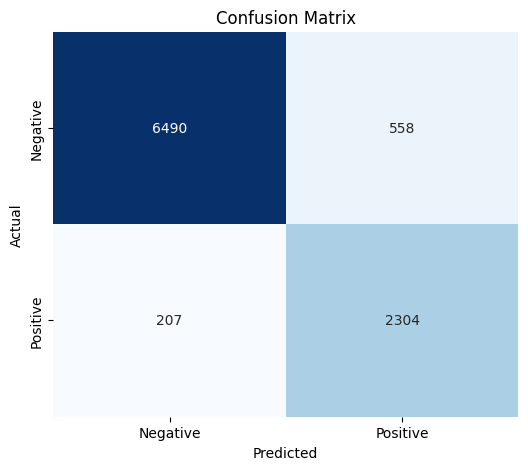

In [17]:
# ========================================================================
# PHASE 7 — Evaluation
# ========================================================================
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load Saved Model
print("Loading best saved model...")
loaded_model = AutoModelForSequenceClassification.from_pretrained("best_tunisian_model")
loaded_model.to(device)
loaded_model.eval()

# 2. Run Inference on Test Set
print("Running inference on test set...")

def get_predictions(model, data_loader, device):
    model = model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds.cpu().tolist())
            real_values.extend(labels.cpu().tolist())

    return predictions, real_values

y_pred, y_test = get_predictions(loaded_model, test_loader, device)

# 3. Compute Metrics
print("\n" + "="*50)
print("TEST SET RESULTS")
print("="*50)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Optional: Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [18]:
import torch
import torch.nn.functional as F

def predict_sentiment(text, model, tokenizer, device):
    # 1. Preprocess the text (using the function defined in Phase 1)
    cleaned_text = preprocess_text(text)

    # 2. Tokenize
    inputs = tokenizer(
        cleaned_text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=64
    ).to(device)

    # 3. Run Inference
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        # Apply Softmax to get probabilities (0 to 1)
        probs = F.softmax(outputs.logits, dim=1)

        # Get the predicted class (0 or 1) and the confidence score
        pred_idx = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_idx].item()

    # 4. Map to Label
    # Assuming 0 = Negative, 1 = Positive based on your classification report
    labels = {1: "Negative",0: "Positive"}

    return labels[pred_idx], confidence

# --- Test the specific sentence ---
sentence = "zeyed ga3bout w matjich rajel"

# Predict on raw Arabizi
label, score = predict_sentiment(sentence, loaded_model, tokenizer, device)

print("-" * 30)
print(f"Input Text:  {sentence}")
print(f"Prediction:  {label}")
print(f"Confidence:  {score:.4f}")
print("-" * 30)

transliterated = transliterator.transliterate_text(sentence, use_vocab_matching=True)
label_ar, score_ar = predict_sentiment(transliterated, loaded_model, tokenizer, device)

print(f"Transliterated: {transliterated}")
print(f"Prediction (Ar): {label_ar} ({score_ar:.4f})")
print("-" * 30)


------------------------------
Input Text:  zeyed ga3bout w matjich rajel
Prediction:  Negative
Confidence:  0.7177
------------------------------
Transliterated: زايد اعبو و ماتجيوش اجال
Prediction (Ar): Negative (0.9861)
------------------------------


In [33]:
# ========================================================================
# PHASE 8 — Feature Extraction for Classical ML
# ========================================================================
# We extract embeddings from the BASE MARBERT model (not the fine-tuned classifier).

from transformers import AutoModel

print("\n" + "="*50)
print("FEATURE EXTRACTION (Base MARBERT)")
print("="*50)

# Load base MARBERT and freeze weights for pure embeddings
base_model = AutoModel.from_pretrained("UBC-NLP/MARBERT", output_hidden_states=True)
for p in base_model.parameters():
    p.requires_grad = False
base_model.eval()
base_model.to(device)

# Ensure hidden states are returned (safety)
base_model.config.output_hidden_states = True


def extract_embeddings(model, data_loader, device):
    embeddings = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Extracting"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden_state = outputs.hidden_states[-1]
            cls_emb = last_hidden_state[:, 0, :].cpu().numpy()

            embeddings.append(cls_emb)
            labels.append(batch_labels.numpy())

    return np.vstack(embeddings), np.concatenate(labels)

print("Extracting embeddings for Train set (base MARBERT)...")
X_train, y_train = extract_embeddings(base_model, train_loader, device)

print("Extracting embeddings for Validation set (base MARBERT)...")
X_val, y_val = extract_embeddings(base_model, val_loader, device)

print("Extracting embeddings for Test set (base MARBERT)...")
X_test, y_test = extract_embeddings(base_model, test_loader, device)

print(f"\nFeature shapes:")
print(f"Train: {X_train.shape}")
print(f"Val:   {X_val.shape}")
print(f"Test:  {X_test.shape}")



FEATURE EXTRACTION (Base MARBERT)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: UBC-NLP/MARBERT
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Extracting embeddings for Train set (base MARBERT)...


Extracting:   0%|          | 0/2512 [00:00<?, ?it/s]

Extracting embeddings for Validation set (base MARBERT)...


Extracting:   0%|          | 0/598 [00:00<?, ?it/s]

Extracting embeddings for Test set (base MARBERT)...


Extracting:   0%|          | 0/598 [00:00<?, ?it/s]


Feature shapes:
Train: (40180, 768)
Val:   (9559, 768)
Test:  (9559, 768)



LOGISTIC REGRESSION
Tuning C parameter: [0.01, 0.1, 1, 5, 10]
  C=0.01  -> Val Accuracy: 0.7321
  C=0.1   -> Val Accuracy: 0.7631
  C=1     -> Val Accuracy: 0.7752
  C=5     -> Val Accuracy: 0.7813
  C=10    -> Val Accuracy: 0.7809

Best Logistic Regression (C=5)
------------------------------
Test Accuracy: 0.7846

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

    Negative       0.92      0.78      0.84      7048
    Positive       0.56      0.80      0.66      2511

    accuracy                           0.78      9559
   macro avg       0.74      0.79      0.75      9559
weighted avg       0.82      0.78      0.79      9559


Confusion Matrix (Logistic Regression):
[[5485 1563]
 [ 496 2015]]


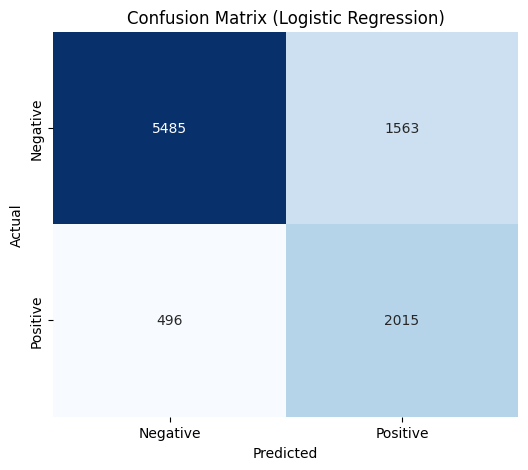


LINEAR SVM
Tuning C parameter: [0.01, 0.1, 1, 5, 10]
  C=0.01  -> Val Accuracy: 0.7594
  C=0.1   -> Val Accuracy: 0.7761
  C=1     -> Val Accuracy: 0.7798
  C=5     -> Val Accuracy: 0.7808
  C=10    -> Val Accuracy: 0.7803

Best Linear SVM (C=5)
------------------------------
Test Accuracy: 0.7844

Classification Report (Linear SVM):
              precision    recall  f1-score   support

    Negative       0.92      0.78      0.84      7048
    Positive       0.56      0.80      0.66      2511

    accuracy                           0.78      9559
   macro avg       0.74      0.79      0.75      9559
weighted avg       0.82      0.78      0.79      9559


Confusion Matrix (Linear SVM):
[[5480 1568]
 [ 493 2018]]


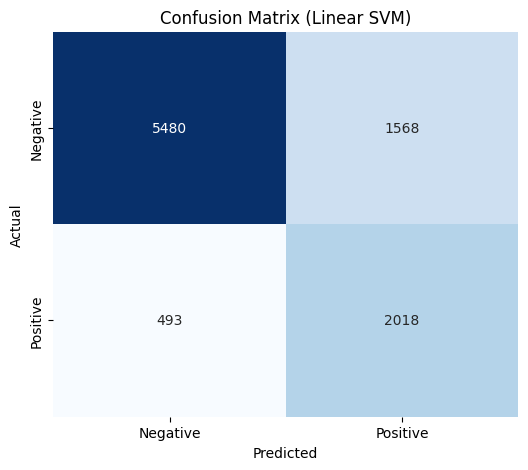

In [34]:
# ========================================================================
# PHASE 9 — Classical ML Models
# ========================================================================
# Train Logistic Regression and SVM on the extracted embeddings.

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------
# 1. Logistic Regression
# ------------------------------------------------------------------------
print("\n" + "="*50)
print("LOGISTIC REGRESSION")
print("="*50)

# Hyperparameter tuning for C
C_values = [0.01, 0.1, 1, 5, 10]
best_lr_acc = 0
best_lr_model = None

print(f"Tuning C parameter: {C_values}")

for c in C_values:
    lr = LogisticRegression(C=c, max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)

    val_pred = lr.predict(X_val)
    acc = accuracy_score(y_val, val_pred)
    print(f"  C={c:<5} -> Val Accuracy: {acc:.4f}")

    if acc > best_lr_acc:
        best_lr_acc = acc
        best_lr_model = lr

print(f"\nBest Logistic Regression (C={best_lr_model.C})")
print("-" * 30)
test_pred_lr = best_lr_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, test_pred_lr):.4f}")
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, test_pred_lr, target_names=['Negative', 'Positive']))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, test_pred_lr)
print("\nConfusion Matrix (Logistic Regression):")
print(cm_lr)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Logistic Regression)')
plt.show()


# ------------------------------------------------------------------------
# 2. Linear SVM
# ------------------------------------------------------------------------
print("\n" + "="*50)
print("LINEAR SVM")
print("="*50)

best_svm_acc = 0
best_svm_model = None

print(f"Tuning C parameter: {C_values}")

for c in C_values:
    # dual='auto' chooses best algorithm based on n_samples vs n_features
    svm = LinearSVC(C=c, max_iter=2000, random_state=42, dual='auto')
    svm.fit(X_train, y_train)

    val_pred = svm.predict(X_val)
    acc = accuracy_score(y_val, val_pred)
    print(f"  C={c:<5} -> Val Accuracy: {acc:.4f}")

    if acc > best_svm_acc:
        best_svm_acc = acc
        best_svm_model = svm

print(f"\nBest Linear SVM (C={best_svm_model.C})")
print("-" * 30)
test_pred_svm = best_svm_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, test_pred_svm):.4f}")
print("\nClassification Report (Linear SVM):")
print(classification_report(y_test, test_pred_svm, target_names=['Negative', 'Positive']))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, test_pred_svm)
print("\nConfusion Matrix (Linear SVM):")
print(cm_svm)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Linear SVM)')
plt.show()



VISUALIZATION
Explained variance ratio: [0.7656882  0.13903275]


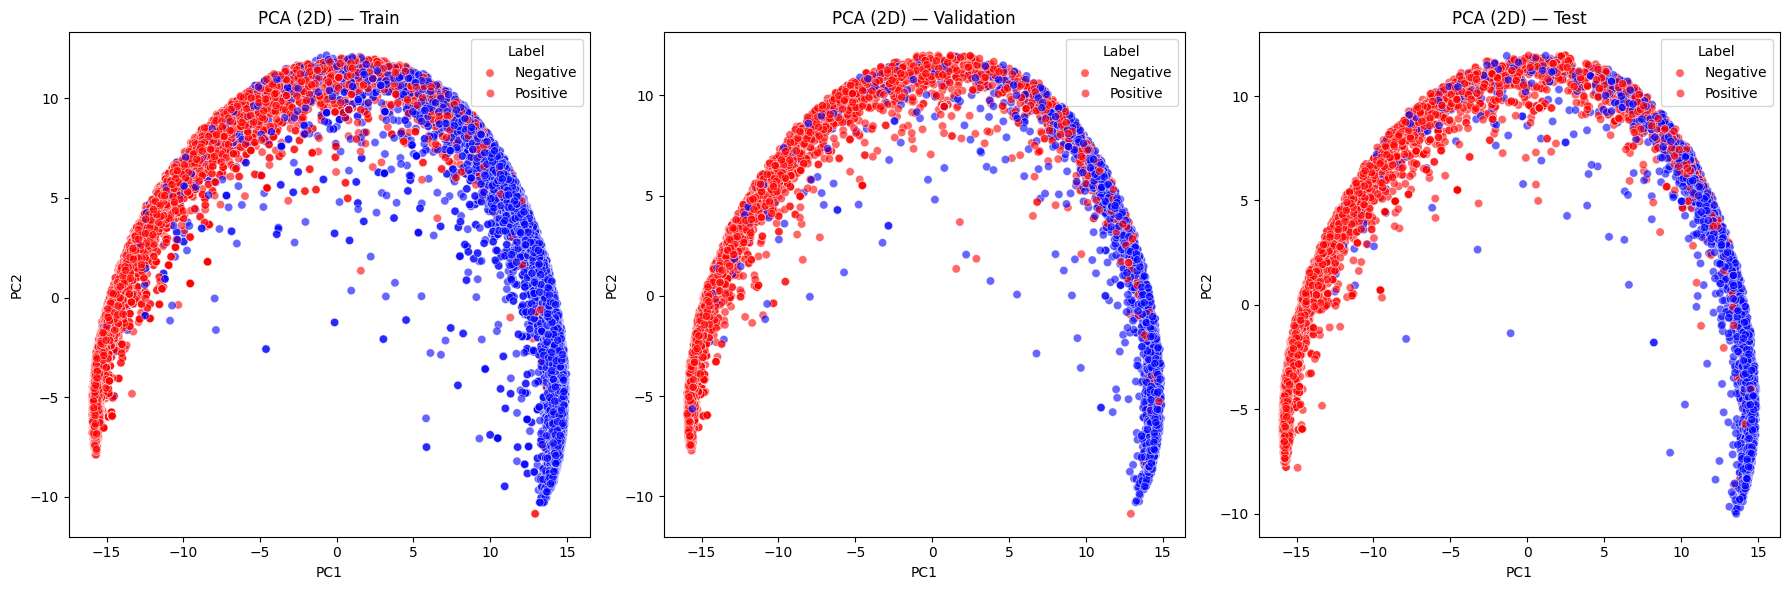

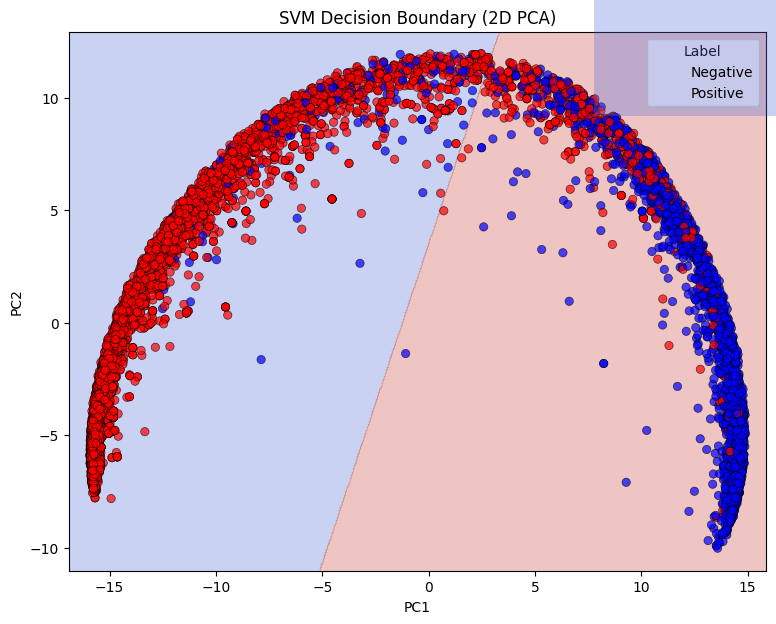

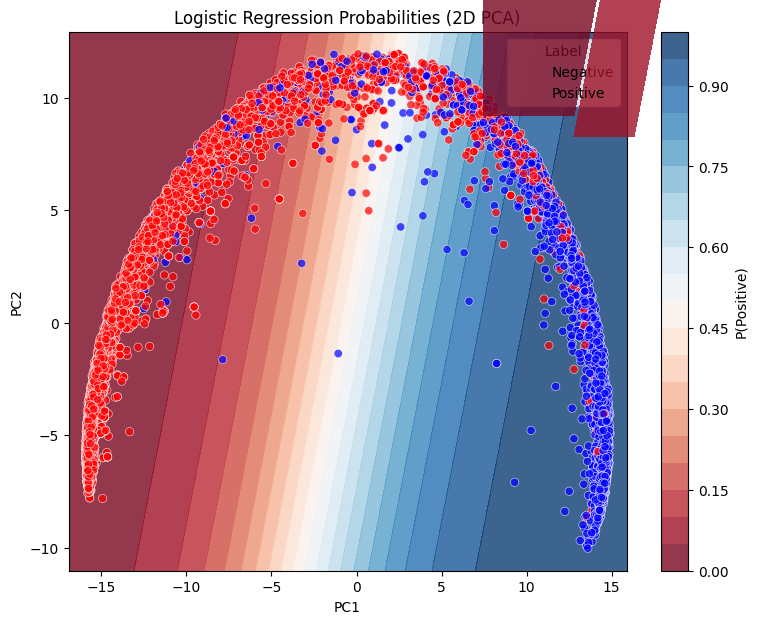

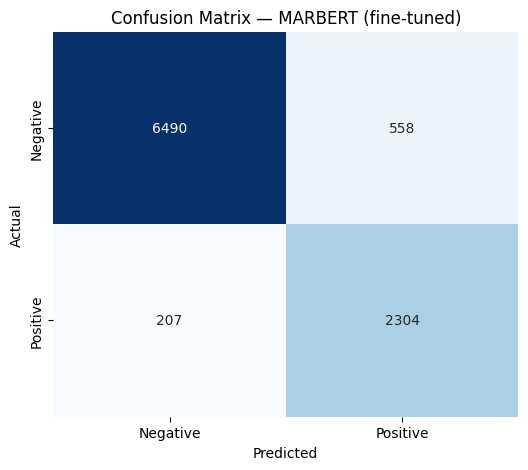

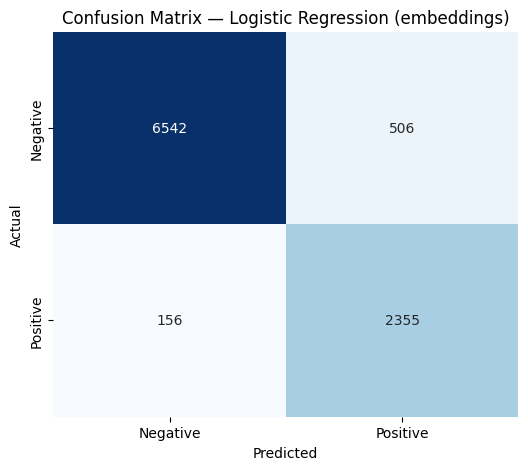

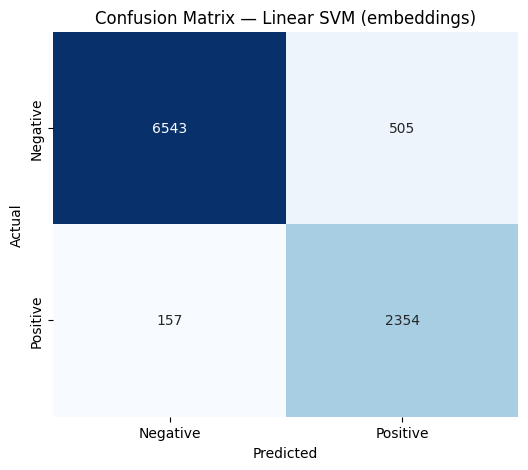

In [23]:
# ========================================================================
# PHASE 10 — Plots (PCA & Decision Boundaries)
# ========================================================================
# PCA (768 -> 2D), class scatter, SVM/LR boundaries, probability map, confusion matrices.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

print("\n" + "="*50)
print("VISUALIZATION")
print("="*50)

# PCA to 2D
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# Scatter by label (train/val/test)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, data, labels, title in [
    (axes[0], X_train_pca, y_train, "Train"),
    (axes[1], X_val_pca, y_val, "Validation"),
    (axes[2], X_test_pca, y_test, "Test"),
]:
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=labels,
                    palette={0: "red", 1: "blue"}, alpha=0.6, ax=ax)
    ax.set_title(f"PCA (2D) — {title}")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend(title="Label", labels=["Negative", "Positive"])
plt.tight_layout()
plt.show()

# Train lightweight 2D models for boundary visualizations
svm_2d = LinearSVC(C=1.0, max_iter=2000, dual="auto", random_state=42)
svm_2d.fit(X_train_pca, y_train)
lr_2d = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
lr_2d.fit(X_train_pca, y_train)

# Mesh grid
h = 0.05
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

# SVM decision boundary
Z_svm = svm_2d.predict(grid).reshape(xx.shape)
plt.figure(figsize=(9, 7))
plt.contourf(xx, yy, Z_svm, cmap=plt.cm.coolwarm, alpha=0.3)
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=y_test,
                palette={0: "red", 1: "blue"}, alpha=0.7, edgecolor="k")
plt.title("SVM Decision Boundary (2D PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Label", labels=["Negative", "Positive"])
plt.show()

# Logistic Regression probability contour
Z_lr = lr_2d.predict_proba(grid)[:, 1].reshape(xx.shape)
plt.figure(figsize=(9, 7))
contour = plt.contourf(xx, yy, Z_lr, cmap="RdBu", levels=20, alpha=0.8)
plt.colorbar(contour, label="P(Positive)")
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=y_test,
                palette={0: "red", 1: "blue"}, alpha=0.7, edgecolor="white")
plt.title("Logistic Regression Probabilities (2D PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Label", labels=["Negative", "Positive"])
plt.show()

# Confusion matrices: fine-tuned MARBERT and classical models
# MARBERT
cm_marbert = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_marbert, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix — MARBERT (fine-tuned)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Logistic Regression (full 768-d)
cm_lr_full = confusion_matrix(y_test, test_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr_full, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix — Logistic Regression (embeddings)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Linear SVM (full 768-d)
cm_svm_full = confusion_matrix(y_test, test_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_svm_full, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix — Linear SVM (embeddings)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [32]:
# Quick test: predict with the Linear SVM (using CLS embedding from fine-tuned MARBERT)

def get_cls_embedding(text: str, tokenizer, model, device, max_length: int = 64):
    encoded = tokenizer(text, return_tensors="pt", padding="max_length",
                        truncation=True, max_length=max_length).to(device)
    with torch.no_grad():
        outputs = model(**encoded)
        cls_vec = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
    return cls_vec

sentence = "bhim"
cls_emb = get_cls_embedding(sentence, tokenizer, loaded_model, device)
svm_pred = best_svm_model.predict(cls_emb)[0]
label_map = {1: "Negative", 0: "Positive"}
print(f"SVM prediction for '{sentence}': {label_map.get(svm_pred, svm_pred)} (class {svm_pred})")


SVM prediction for 'bhim': Negative (class 1)
